### Fine-tuning mt5 for cleaning italian ocr text
In the following notebook we fine-tune **mt5-base** for cleaning italian ocr-text.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm 
import evaluate
import numpy as np
from datasets import Dataset
from datasets import load_from_disk
from datasets import concatenate_datasets
import seaborn as sns
import json
import random


2025-09-04 10:21:50.799860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load datasets

In [3]:
train = load_from_disk("../datasets/t5-datasets/train")

# We reserve a 5% of the training set for evaluation
train = train.train_test_split(test_size=0.05)

In [4]:
train_dataset = train['train']
eval_dataset = train['test']

#### Load mt5-base and its tokenizer

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained("../../mt5-base")
tokenizer = AutoTokenizer.from_pretrained("../../mt5-base")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/gjergj/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Data Preparation

Before proceeding let's first check the length of the encoded samples.

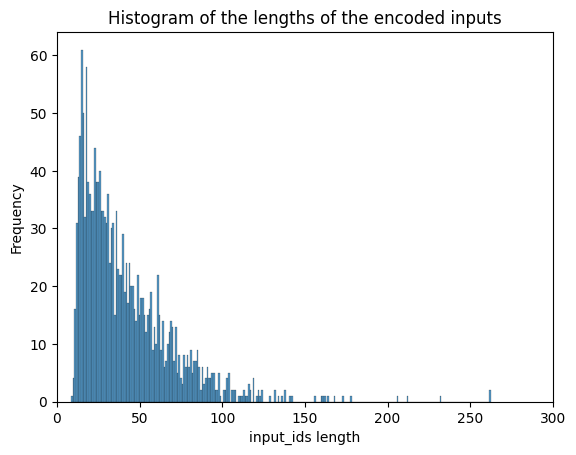

In [6]:
encoded_inputs_length = [] # store the length of the encoded samples

for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')
    encoded_inputs_length.append(len(input_ids[0]))


encoded_inputs_length.sort(reverse=True)

sns.histplot(encoded_inputs_length, bins=10, discrete=True)

plt.xlim(0, 300)
plt.xlabel('input_ids length')
plt.ylabel('Frequency')
plt.title('Histogram of the lengths of the encoded inputs')

plt.show()

In [7]:
print(model.config.max_length)

20


As showed above, the predefined input length of mt5 is 20 tokens, but as we can see from the histogram above, a significant number of tokenized samples are longer. Therefore, in order to not lose too much data, instead of just truncating the samples, we create chunks of 20 tokens. As an example, the two strings:

ocr:  
" \n—  Kagazzo  mio,  —  disse  la  Fata  —  quelli  che \ndicono  così.  Uniscono  quasi  sempre  o  in  carcere \no  all'ospedale."

clean:  
"— Ragazzo mio, — disse la Fata — quelli che dicono così, finiscono quasi sempre o in carcere o all’ospedale."

become:
```
ocr_tokens: ['▁—', '▁Kaga', 'zzo', '▁mio', ',', '▁—', '▁disse', '▁la', '▁Fata', '▁—', '▁quell', 'i', '▁che', '▁di', 'cono', '▁cos', 'ì', '.', '▁Un', '</s>'], 
clean_tokens: ['▁—', '▁Rag', 'azzo', '▁mio', ',', '▁—', '▁disse', '▁la', '▁Fata', '▁—', '▁quell', 'i', '▁che', '▁di', 'cono', '▁cos', 'ì', ',', '▁fin', '</s>']


ocr_tokens: ['iscono', '▁quasi', '▁sempre', '▁', 'o', '▁in', '▁', 'carcer', 'e', '▁', 'o', '▁all', "'", 'os', 'pedale', '.', '</s>', '<pad>', '<pad>', '<pad>'], 
clean_tokens: ['iscono', '▁quasi', '▁sempre', '▁', 'o', '▁in', '▁', 'carcer', 'e', '▁', 'o', '▁all', '’', 'os', 'pedale', '.', '</s>', '<pad>', '<pad>', '<pad>']
```
In order to produce such chunks, we used used the `sequence-alignment` algorithm, proposed by Needleman and Wunsch for aligning biological sequences. As explained better later, we used the algorithm for aligning the ocr tokens with the clean ones, and then we split the samples in order to produce chunks of 20 tokens.


**Data Augmentation**  
Before proceeding in splitting the samples in chunks of 20 tokens, we consider the possibility of applying some data augumentation. To do so, we define a dictionary with the most common mistakes (for example `i → 1 or l`, `m → rn`, `n → ri` and so on) committed by ocr systems. Then, each time we encounter one of the keys of the dictionary, we manually make the substitution with a probablity $p$. For simplicity we select samples that are no longer than 18 tokens, which correspond to roughly 5% of the training dataset. 

In [8]:
# First we select some candidate samples, to which apply might apply some augmentation

candidates = [] 
for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')[0]
    if len(input_ids) < 19:
        candidates.append(sample)


In [9]:
common_errors = {'i': ['1', 'l'], 'o': ['0'], 'm': ['rn'], 'n': ['ri'], 'l':['1'], 'c': ['e'], 
                 'a': ['o'], 'r':['v'], 't': ['f'], 's':['5'], 'z': ['2'], 'b': ['h', 'l'], 
                 'rn': ['m'], 'ri': ['n'], 'cl': ['d'], 'li': ['h'], 'vv': ['w'], 'lu': ['U'], 
                 'è': ['e', 'é'], 'ò': ['o', 'ó'], 'à': ['a', 'á']}

def augment_data(samples, p):

    ''' 
    - samples to which apply data augmentation
    - p: probability that a character or a bigram is changes with one of the common erros
         NOTE: we keep this probablity very low (around 10 %) since the ocr samples 
               present already a lot of noise   
    '''
    modified_samples = []

    keys = common_errors.keys()
    for sample in candidates:
        # check characters
        modified = False
        ocr_sample = sample['ocr']
        for i in range(len(ocr_sample)):
            c = ocr_sample[i]
            if c in keys:
                rv = random.random()
                if p >= rv:
                    ocr_sample = ocr_sample[:i] + random.choice(common_errors[c]) + ocr_sample[i+1:]
                    modified = True

        # check bigrams
        for i in range(0, len(ocr_sample), 2):
            bigram = ocr_sample[i: i+2]

            if bigram in keys:
                rv = random.random()
                if p >= rv:
                    ocr_sample = ocr_sample[:i] + random.choice(common_errors[bigram]) + ocr_sample[i+2:]
                    modified = True

        # if the sample was modified, we store it 
        if modified:
            new_sample = {}
            new_sample['ocr'] = ocr_sample
            new_sample['clean'] = sample['clean']
            modified_samples.append(new_sample)
    
    return modified_samples


In [10]:
modified_samples = augment_data(candidates, p=0.10)

print(f"Total modified samples: {len(modified_samples)}\n")

# Let's print the first 10 samples
for i in range(10):
    print(modified_samples[i])

Total modified samples: 299

{'ocr': '  !  Po- \ntrei puriirvi,  ma  5ì  vii  non  sono', 'clean': 'Potrei punirvi, ma sì vil non sono!'}
{'ocr': '  —  ur1ò  Pi- \nnocchio, vicominciando  a  p1ongere.', 'clean': '— urlò Pinocchio, ricominciando a piangere.'}
{'ocr': ' \n\n\nQuello  che  mangiò  meno  di  tatti  fu  Pin0cchio.', 'clean': 'Quello che mangiò meno di tutti fu Pinocchio.'}
{'ocr': ' \nFiguratevl  ll  povero  Pinocchio', 'clean': 'Figuratevi il povero Pinocchio!'}
{'ocr': '  ! \n—  E  eome  avete  fafto  a  eampare?', 'clean': '— E come avete fatto a campare?'}
{'ocr': ' \n—  In  che  mondo  5iamo  c0ndannati  a  vivere', 'clean': '— In che mondo siamo condannati a vivere?'}
{'ocr': "  Non  pu0i \nsbagliave. \n—  Mi  dica  un'  altra  cosa.", 'clean': 'Non puoi sbagliare.— Mi dica un’altra cosa.'}
{'ocr': ' \n—  Fuori  Pinoechio!  Vog1iamo  i1  ciuchirio!', 'clean': '— Fuori Pinocchio!Vogliamo il ciuchino!'}
{'ocr': "  Ma  la \nCa5ina  lianca  non  e'  era  più.", 'clean': '

In [11]:
# convert the new samples in a hugging face Dataset and concatenate it with 
# the original train set
augmented_samples = Dataset.from_list(modified_samples)
train_dataset = concatenate_datasets([train_dataset, augmented_samples])
print(train_dataset)

Dataset({
    features: ['ocr', 'clean'],
    num_rows: 2012
})


#### Sequence-alignment 

Now we proceed with splitting the samples in chunks of 20 tokens, and, in order to do so, we use the `sequence-alignment` algorithm, usually adopted in bioinformatics for aligning sequences of genes. The idea is the following.  
Say we want to align the strings *stop* and *tops*. A possibility is:  

`stop-`  
`-tops`  

As it can be seen there from the simple example considered above, there are two aspects that we need to clarify:
1. First, it might not be possible at all to match a character with another one (this is clear when the length of the two strings is different), therefore we'll need to define a parameter $\delta > 0$, that represents the **gap penalty**.
2. Second, we need to define a mismatch cost $\alpha > 0$, i.e. a price that we "pay" whenever we align two different characters.   

Now, with that said, we have three possible cases that can occur. Consider an optimal alignment *M* of two string *X* and *Y*, then at least one of the follwing is true:
1. $(m, n) \in M$; 
2. the $m^{th}$ position of X is not matched;
3. the $n^{th}$ position of Y in not matched;

With these observations we can define the follwoing recursion that computes the mimimum cost for aligning two sequences:  
$$OPT(i, j) = min[\alpha_{x_iy_j} + OPT(i-1, j-1), \delta + OPT(i-1, j), \delta + OPT(i, j-1)]$$

Using the recursion above, we can implement an algorithm that computes the *minimum-cost* for aligning two sequences. However, this does not output the optimal alignment, but we'll need to retrieve it.  
To birefly give an intuition, consider the picture above, where the algorithm tries to align *name* with *mean*.  

 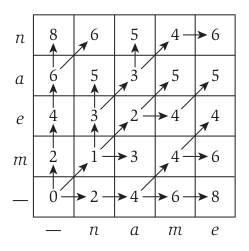

If we look at the matrix as a graph, it can be shown that the value of the optimal alignment is the length if the shortest path from the node $(0, 0)$ to $(m, n)$. Following the arrows backward from from node (4, 4), we can trace back to reconstruct the alignment.  
So, to reconstruct:
1. Trace back through the filled table, startin at M[m, n]
2. If M[i, j] was filled using:
    1. case 1, go to $(i-1, j-1)$
    2. case 2, go to $(i-1, j)$
    3. case 3, go to $(i, j-1)$
3. If either i = 0 or j = 0, match the remaining substring with *gaps*.  

NOTE: Here we will apply the algorithm to align tokens instead of of characters.


In [2]:
def sequence_alignment(A, B, delta, alpha):
    ''' 
    - A: token ids of the ocr sample
    - B: token ids of the clean sample 
    - delta: penalty gap
    - alpha: penalty mismatch
    '''
    m = len(A)
    n = len(B)

    # As gap token we use: @ → 1250 (beacuse it never occurs in the dataset, and it is encoded with just one value)
    gap_token = 1250


    # initaliaze the matrix
    M = np.zeros((m+1, n+1), dtype=int)

    # for purposes of initialization, we fill the first row and the first column 
    # with the cost that we would pay to align an i-letter word with a 0-letter
    # word. And the only way to do so is by using gaps
    for i in range(m+1):
        M[i, 0] = i * delta 

    for j in range(n+1):
        M[0, j] = j * delta 

    # Now we compute the cost matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if A[i-1] == B[j-1] else alpha

            M[i, j] = min(cost + M[i-1, j-1], delta + M[i-1, j], delta + M[i, j-1])



    # In the following we backtrack from the cost matrix to 
    # reconstuct the solution
    l = n + m
    i = m
    j = n

    ocr_pos = l
    clean_pos = l 

    ocr = np.zeros(l+1, dtype=int)
    clean = np.zeros(l+1, dtype=int)

    while not (i == 0 or j == 0):
        if A[i-1] == B[j-1]:    # case where the two tokens match
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1
            clean_pos -= 1 
            i -= 1 
            j -= 1 

        elif (M[i-1][j-1] + alpha) == M[i][j]:  # case where we have a mismatch
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1 
            clean_pos -= 1
            i -= 1
            j -= 1 

        elif (M[i-1][j] + delta) == M[i][j]:    # case where we use a gap
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = gap_token
            ocr_pos -= 1
            clean_pos -= 1 
            i -= 1

        elif (M[i][j-1] + delta) == M[i][j]:    # case where we use a gap
            ocr[ocr_pos] = gap_token
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1
            clean_pos -= 1
            j -= 1 
    
   
   # If needed, fill the remaining positions with gaps
    while ocr_pos > 0:
        if i > 0:
            i -= 1
            ocr[ocr_pos] = A[i]
            ocr_pos -= 1
        else:
            ocr[ocr_pos] = gap_token
            ocr_pos -= 1

    while clean_pos > 0:
        if j > 0:
            j -= 1
            clean[clean_pos] = B[j]
            clean_pos -= 1

        else:
            clean[clean_pos] = gap_token
            clean_pos -= 1

    # since we have assumed that the final answer is long m + n, 
    # we remove the gaps from the initial positions. 
    # The variable 'id' will store the starting index from where 
    # to retireve the aligned sequences
    id = 1
    i = l

    while i > 0:
        if ocr[i] == gap_token and clean[i] == gap_token:   # if both the positions are filled with a gap, skip them
            id = i + 1
            break 

        i -= 1

    # Now ì, we are finally ready to retrieve the aligned sequences
    i = id
    x_seq = []

    while i <= l:
        x_seq.append(ocr[i])
        i += 1


    i = id 
    y_seq = []

    while i <= l:
        y_seq.append(clean[i])
        i += 1 
   

    return torch.tensor(x_seq), torch.tensor(y_seq)


        

Now, we proceed with the implementation of two auxiliary functions:
1. `pad`: function that ensures that the `</s>` (end of sequence) token is always present in each sample and that each sample is padded to the desried lenght (20 tokens)
2. `chunk_dataset`: auxiliary function that tokenizes each sample, calls the sequence-alignment algorithm to align the ocr tokens with the clean ones, and finally outputs the desired chunks.

In [3]:
def pad(ocr_chunk, clean_chunk):
    if ocr_chunk[-1].item() != 1:       # if needed, add </s> (EOS) token
        ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))

    if len(ocr_chunk) < 20:             # if needed, pad to the desired length
        while len(ocr_chunk) < 20:
            ocr_chunk = torch.cat((ocr_chunk, torch.tensor([0])))   

    # we do the same for the clean sample
    if clean_chunk[-1].item() != 1:
        clean_chunk = torch.cat((clean_chunk,  torch.tensor([1])))

    if len(clean_chunk) < 20:
        while len(clean_chunk) < 20:
            clean_chunk = torch.cat((clean_chunk, torch.tensor([0])))

    return (ocr_chunk, clean_chunk)

In [4]:
def chunk_dataset(dataset, tokenizer):
    ''' 
    - dataset: test dataset
    - tokenizer: mt5 tokenizer
    '''
    chunked_dataset = {}
    chunked_dataset['ocr'] = []
    chunked_dataset['clean'] = []

    tokenized_chunked_dataset = {}
    tokenized_chunked_dataset['ocr'] = []
    tokenized_chunked_dataset['clean'] = []

    gap_token = 1250    # @ → we will remove this from the samples

    # It can happen that some chunks are empty, or are composed
    # by just one 'special' symbol (e.g. !, ?, .). We remove such 
    # extreme cases
    elems = ['', ',', '.', '?', '!']   


    for sample in dataset:
        ocr_sample = sample['ocr']
        clean_sample = sample['clean']

        # compute the token ids
        encoded_ocr = tokenizer.encode(ocr_sample, return_tensors='pt')[0]
        encoded_clean = tokenizer.encode(clean_sample, return_tensors='pt')[0]

        # align the token ids
        ocr_seq, clean_seq = sequence_alignment(encoded_ocr, encoded_clean, delta=2, alpha=1)
        
        # Now we can proceede and produce chunks of 20 tokens
        for i in range(0, len(ocr_seq), 19):

            ocr_chunk = ocr_seq[i: i+19]
            clean_chunk = clean_seq[i: i+19]

            # remove the gap token
            mask = ocr_chunk != gap_token
            ocr_chunk = ocr_chunk[mask]

            mask = clean_chunk != gap_token
            clean_chunk = clean_chunk[mask]

            decoded_ocr = tokenizer.decode(ocr_chunk, skip_special_tokens=True)
            decoded_clean = tokenizer.decode(clean_chunk, skip_special_tokens=True)

            # remove samples that are empty or composed by just 
            # one "special" character 
            if decoded_ocr in elems or decoded_clean in elems:
                continue

            # make sure that the last elem is the </s> token and
            # pad to the desired length
            ocr_chunk, clean_chunk = pad(ocr_chunk, clean_chunk)

            chunked_dataset['ocr'].append(decoded_ocr)
            chunked_dataset['clean'].append(decoded_clean)

            tokenized_chunked_dataset['ocr'].append(ocr_chunk)
            tokenized_chunked_dataset['clean'].append(clean_chunk)

    return chunked_dataset, tokenized_chunked_dataset

            

In [15]:
chunked_train_data, tokenized_chunked_train_data = chunk_dataset(train_dataset, tokenizer)
chunked_eval_data, tokenized_chunked_eval_data = chunk_dataset(eval_dataset, tokenizer)

In [16]:
# Let's print the first 10 samples and look at the result
i = 0
for ocr, clean in zip(chunked_train_data['ocr'], chunked_train_data['clean']):
    print(f'ocr: {ocr},  clean: {clean}')
    i += 1
    if i == 10:
        break

ocr: sulla porta, si ricordò che aveva gli orecchi d'asi- no,,  clean: sulla porta, si ricordò che aveva gli orecchi d’asino,
ocr: e vergognandosi di mostrarli in pubblico, che cosa inventò?,  clean: e vergognandosi di mostrarli in pubblico, che cosa inventò?
ocr: ! Po- trei punirvi, ma sì vii non sono,  clean: Potrei punirvi, ma sì vil non sono!
ocr: — urlò Pi- nocchio, ricominciando a piangere.,  clean: — urlò Pinocchio, ricominciando a piangere.
ocr: Lucignolo era il ragazzo più svogliato e più birichino di ,  clean: Lucignolo era il ragazzo più svogliato e più birichino di 
ocr: tutta la scuola: m:i Pinocchio gli voleva un gran bene.,  clean: tutta la scuola: ma Pinocchio gli voleva un gran bene.
ocr: — Pinocchio non se lo fece dire due volte: prese subito il sacchetto,  clean: — Pinocchio non se lo fece dire due volte: prese subito il sacchetto
ocr: dei lupini che era vuoto, e dopo averci fatto colle forbici,  clean: dei lupini che era vuoto, e dopo averci fatto colle forbici
ocr:

In [17]:
# Sanity check, verify that the produced chuncks have all size 20
dataset_size = len(tokenized_chunked_train_data['ocr'])
for i in range(dataset_size):
    if tokenized_chunked_train_data['ocr'][i].shape != torch.Size([20]) or tokenized_chunked_train_data['clean'][i].shape != torch.Size([20]):
        print(i)
        print(tokenized_chunked_train_data['ocr'][i])
        print(tokenized_chunked_train_data['clean'][i])
        print('ERROR: something went wrong')
        break
print("All fine")

All fine


Let's see what a sample looks like.

In [52]:
# Let's now take a random sample and retrieve the original text
ocr = tokenized_chunked_train_data['ocr'][858]
clean = tokenized_chunked_train_data['clean'][858]

print(f'ocr_input_ids: \n {ocr}\nclean_input_ids:\n{clean}\n')

# let's decode the samples
ocr_text = tokenizer.decode(ocr, skip_special_tokens=True)
clean_text = tokenizer.decode(clean, skip_special_tokens=True)

print(f'ocr_text: {ocr_text}\nclean_text: {clean_text}')

ocr_input_ids: 
 tensor([   834,   4735,   2972,   3784,    259,  14730, 211172,    266,    261,
         17884,    834,    529,    264,    568,  27798,    259,    280,    277,
        153465,      1])
clean_input_ids:
tensor([   834,   4735,   2972,   3784,    259,  14730, 211172,    266,    261,
         17884,    834,    259,  13299,    522,    259,    280,    293, 153465,
             1,      0])

ocr_text: va fuori gli altri pesci, sentiva ve- nirsi l'acqu
clean_text: va fuori gli altri pesci, sentiva venirsi l’acqu


### Dataset Preparation

In [5]:
class CustomDataset(data.Dataset):

    def __init__(self, dataset):
        super().__init__()

        ''' 
        - dataset: Python dictionary of the form:
                   {'ocr': [list of ocr samples], 'clean': [list of the corresponding clean samples]}
        '''
        
        self.data = []
        self.num_samples = len(dataset['ocr'])
        self.ocr_samples = dataset['ocr']
        self.clean_samples = dataset['clean']

        # training data will be a list of dictionaries
        # each dictionary contains two keys: 'ocr' and 'clean' 

        for i in range(self.num_samples):
            ocr_sample = self.ocr_samples[i]
            clean_sample = self.clean_samples[i]

            sample = {'ocr': ocr_sample, 'clean': clean_sample}
            self.data.append(sample)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        return self.data[index]
    

In [54]:
training_samples = CustomDataset(dataset=tokenized_chunked_train_data)
val_samples = CustomDataset(dataset=tokenized_chunked_eval_data)  

### Training 

In [55]:
# training hyperparameters
n_epochs = 2
train_batch_size = 8
eval_batch_size = 4
print_freq = 25
lr = 5e-4
len_dataset = len(training_samples)
n_batches = int(np.ceil(len_dataset / train_batch_size))
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01)

In [56]:
print(f'Total Steps: {total_steps}')
print(f'Warmup Steps: {n_warmup_steps}')

Total Steps: 1170
Warmup Steps: 11


In [22]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# We define a scheduler that will take care of adapting the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

#### The Trainer class

In [23]:
class Trainer():

    def __init__(self, model, optimizer, scheduler, num_epochs):
        self.model = model 
        self.optimizer = optimizer
        self.scheduler = scheduler 
        self.num_epochs = num_epochs

    def train(self, train_dataset, val_dataset):

        train_loss = []
        val_loss = []
        for epoch_idx in range(n_epochs):   

            for batch_idx, sample in tqdm(enumerate(train_dataset), total=n_batches):

                input_batch = sample['ocr']
                label_batch = sample['clean']

                # zero the gradients
                optimizer.zero_grad()

                # forward pass
                model_out = model.forward(
                    input_ids = input_batch, 
                    labels = label_batch    # not strictly necessarily, but if we do it,
                                            # it computes the loss for us
                )

                loss = model_out.loss
                train_loss.append(loss.item())

                # compute the gradients
                loss.backward()

                # update the weights
                optimizer.step()

                # The scheduler adaptes the leraning rate
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    #average loss for the last 'print_freq' batches
                    avg_loss = np.mean(train_loss[-print_freq:])
                    eval_loss = self.eval_model(val_dataset)
                    val_loss.append(eval_loss)
                    print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
                        epoch_idx+1, batch_idx+1, avg_loss, eval_loss, scheduler.get_last_lr()[0]))


            model.save_pretrained(f"../model/checkpoints/mt5-base-run3-{epoch_idx}")
            tokenizer.save_pretrained(f"../model/checkpoints/mt5-base-run3-{epoch_idx}")            

        return {
            "train_loss": train_loss, 
            "val_loss": val_loss
        }
    

    def eval_model(self, validation_dataset):
        eval_losses = []

        with torch.no_grad():
            for sample in validation_dataset:
                input_batch = sample['ocr']
                label_batch = sample['clean']

                # forward pass
                model_out = model.forward(input_ids=input_batch, 
                                        labels=label_batch)     # As before we pass also the labels, so it 
                                                                # computes for us also the loss
            
                eval_losses.append(model_out.loss.item())

        
        return np.mean(eval_losses)

The last thing to do, before training, is to load the data using the `DataLoader` module.

In [24]:
training_dataset = DataLoader(training_samples, batch_size=train_batch_size, shuffle=True)
validation_dataset = DataLoader(val_samples, batch_size=eval_batch_size)

In [25]:
trainer = Trainer(model=model,
                  optimizer=optimizer, 
                  num_epochs=n_epochs, 
                  scheduler=scheduler)

In [26]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/583 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 25 | Avg. train loss: 11.151 | Avg. val loss: 5.247 | lr: 0.000493939393939394
Epoch: 1 | Step: 50 | Avg. train loss: 3.646 | Avg. val loss: 1.604 | lr: 0.00048311688311688313
Epoch: 1 | Step: 75 | Avg. train loss: 1.186 | Avg. val loss: 0.940 | lr: 0.00047229437229437225
Epoch: 1 | Step: 100 | Avg. train loss: 0.816 | Avg. val loss: 0.793 | lr: 0.0004614718614718615
Epoch: 1 | Step: 125 | Avg. train loss: 0.664 | Avg. val loss: 0.700 | lr: 0.00045064935064935066
Epoch: 1 | Step: 150 | Avg. train loss: 0.622 | Avg. val loss: 0.595 | lr: 0.00043982683982683984
Epoch: 1 | Step: 175 | Avg. train loss: 0.471 | Avg. val loss: 0.503 | lr: 0.000429004329004329
Epoch: 1 | Step: 200 | Avg. train loss: 0.477 | Avg. val loss: 0.474 | lr: 0.00041818181818181814
Epoch: 1 | Step: 225 | Avg. train loss: 0.454 | Avg. val loss: 0.426 | lr: 0.00040735930735930737
Epoch: 1 | Step: 250 | Avg. train loss: 0.318 | Avg. val loss: 0.389 | lr: 0.00039653679653679655
Epoch: 1 | Step: 275 | Avg.

  0%|          | 0/583 [00:00<?, ?it/s]

Epoch: 2 | Step: 25 | Avg. train loss: 0.122 | Avg. val loss: 0.301 | lr: 0.00024155844155844156
Epoch: 2 | Step: 50 | Avg. train loss: 0.127 | Avg. val loss: 0.305 | lr: 0.00023073593073593074
Epoch: 2 | Step: 75 | Avg. train loss: 0.150 | Avg. val loss: 0.308 | lr: 0.00021991341991341992
Epoch: 2 | Step: 100 | Avg. train loss: 0.132 | Avg. val loss: 0.305 | lr: 0.00020909090909090907
Epoch: 2 | Step: 125 | Avg. train loss: 0.132 | Avg. val loss: 0.306 | lr: 0.00019826839826839827
Epoch: 2 | Step: 150 | Avg. train loss: 0.133 | Avg. val loss: 0.304 | lr: 0.00018744588744588745
Epoch: 2 | Step: 175 | Avg. train loss: 0.129 | Avg. val loss: 0.301 | lr: 0.00017662337662337663
Epoch: 2 | Step: 200 | Avg. train loss: 0.141 | Avg. val loss: 0.300 | lr: 0.0001658008658008658
Epoch: 2 | Step: 225 | Avg. train loss: 0.101 | Avg. val loss: 0.298 | lr: 0.00015497835497835496
Epoch: 2 | Step: 250 | Avg. train loss: 0.164 | Avg. val loss: 0.300 | lr: 0.00014415584415584416
Epoch: 2 | Step: 275 | A

In [27]:
# Save the model and tokenizer
model.save_pretrained("../model/fine-tuned-models/mt5-base-run3")
tokenizer.save_pretrained("../model/fine-tuned-models/mt5-base-run3")

('../model/fine-tuned-models/mt5-base-run3/tokenizer_config.json',
 '../model/fine-tuned-models/mt5-base-run3/special_tokens_map.json',
 '../model/fine-tuned-models/mt5-base-run3/spiece.model',
 '../model/fine-tuned-models/mt5-base-run3/added_tokens.json',
 '../model/fine-tuned-models/mt5-base-run3/tokenizer.json')

#### Plots

In [28]:
def plot(data, label):
    plt.plot(data, label=label)
    plt.legend()
    plt.show()

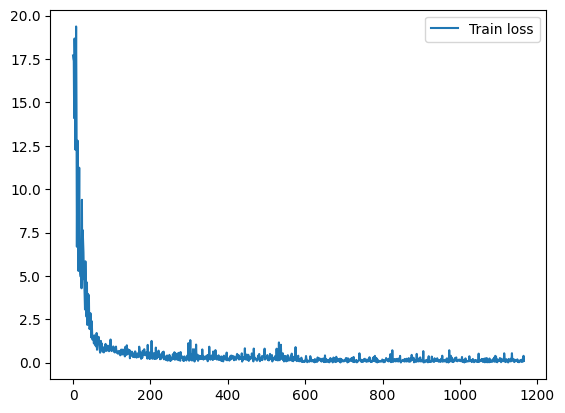

In [29]:
plot(history['train_loss'], label='Train loss')

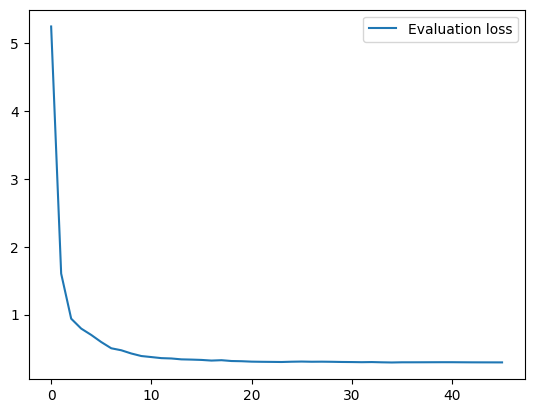

In [30]:
plot(history['val_loss'], label='Evaluation loss')

#### Testing and Inference

In [6]:
# Load the fine-tuned model
mt5_finetuned = AutoModelForSeq2SeqLM.from_pretrained("../model/fine-tuned-models/mt5-base-run3")
mt5_tokenizer = AutoTokenizer.from_pretrained("../model/fine-tuned-models/mt5-base-run3")

In [ ]:
mt5_finetuned.eval()

In [9]:
# Load the test dataset
test = load_from_disk("../datasets/t5-datasets/test")

#### Data preparation for inference

In [10]:
chunked_test_data, tokenized_chunked_test_data = chunk_dataset(test, mt5_tokenizer)

In [11]:
# Let's print the first 10 samples and look at the result
i = 0
for ocr, clean in zip(chunked_test_data['ocr'], chunked_test_data['clean']):
    print(f'ocr: {ocr},  clean: {clean}')
    i += 1
    if i == 10:
        break

ocr: I. Como andò che Maestro Ciliegia, Megnamc trovò un p,  clean: I.Come andò che Maestro Ciliegia, falegname trovò un p
ocr: ezzo di legno che piangeva e rideva come un bambino.,  clean: ezzo di legno che piangeva e rideva come un bambino.
ocr: — C'era una volta.... — Un re!,  clean: — C’era una volta.... — Un re!
ocr: -diranno subito i miei piccoli lettori.,  clean: — diranno subito i miei piccoli lettori.
ocr: — Ko, ragazzi, avete sbagliato.,  clean: — No, ragazzi, avete sbagliato.
ocr: C'era una volta un pezzo di legno.,  clean: C’era una volta un pezzo di legno.
ocr: Kon era un legno di lusso, ma un semplice pezzo da catasta,,  clean: Non era un legno di lusso, ma un semplice pezzo da catasta,
ocr: di quelli che d' inverno si met- tono nelle stufe e,  clean: di quelli che d’inverno si mettono nelle stufe e
ocr: nei caminetti per accendere il fuoco e per riscaldare le stanze,  clean: nei caminetti per accendere il fuoco e per riscaldare le stanze
ocr: Non so come andasse, ma il f

In [12]:
# Sanity check, verify that the produced chunks have all size 20
dataset_size = len(tokenized_chunked_test_data['ocr'])
for i in range(dataset_size):
    if tokenized_chunked_test_data['ocr'][i].shape != torch.Size([20]) or tokenized_chunked_test_data['clean'][i].shape != torch.Size([20]):
        print(i)
        print(tokenized_chunked_test_data['ocr'][i])
        print(tokenized_chunked_test_data['clean'][i])
        print("ERROR: some samples have not size 20")
        break
print("All fine")

All fine


Finally, we are ready to create the test samples and load them.

In [13]:
test_samples = CustomDataset(dataset=tokenized_chunked_test_data)

In [14]:
test_dataset = DataLoader(test_samples, batch_size=8)

#### Rouge Scores
To evaluate the results we'll use the rouge scores.

In [ ]:
metric = evaluate.load("rouge")

In [16]:
def postprocess_text(preds, labels, inputs):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    inputs = [inp.strip() for inp in inputs]

    return preds, labels, inputs

def generate_predictions(dataset, model, tokenizer):
    preds_and_labels = [] # list of dictionaries of type {'in': [], 'hyp': [], 'ref': [] }

    for sample in dataset:
        input_batch = sample['ocr']
        label_batch = sample['clean']

        preds = model.generate(input_batch, num_beams=8, num_return_sequences=1)
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        decoded_inputs = tokenizer.batch_decode(input_batch, skip_special_tokens=True)

        decoded_preds, decoded_labels, decoded_inputs = postprocess_text(decoded_preds, decoded_labels, decoded_inputs)

        for i in range(len(decoded_preds)):
            d = {}
            
            d['in'] = decoded_inputs[i]
            d['hyp'] = decoded_preds[i]
            d['ref'] = decoded_labels[i]

            preds_and_labels.append(d)
        
    return preds_and_labels
    

In [17]:
predictions = generate_predictions(test_dataset, model=mt5_finetuned, tokenizer=mt5_tokenizer)

In [18]:
preds = []
references = []

for sample in predictions:
    preds.append(sample['hyp'])
    references.append(sample['ref'])

rouge_scores = metric.compute(predictions=preds, references=references)
print(rouge_scores)

{'rouge1': 0.9287623993451968, 'rouge2': 0.8663957268255451, 'rougeL': 0.929385523849338, 'rougeLsum': 0.9292232979553721}


In [19]:
# save a .json file with the predictions
with open('../results/mt5-base-output-run3.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)